In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# Load dataset
df = pd.read_csv('f1_2019_to_2022_all_drivers_all_data.csv', low_memory=False)

# Convert 'LapTime' and sector times to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Keep the original 'Driver' and 'Circuit' for EDA, Preprocessing be for one hot encoding
df['Original_Driver'] = df['Driver']
df['Original_Circuit'] = df['Circuit']

# Encode Rainfall, FreshTyre, IsAccurate, and IsPersonalBest to integer
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)

# Drop columns not related to lap time prediction
columns_to_drop = ['Time', 'LapStartTime', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated','IsPersonalBest', 'Sector3Time']
df.drop(columns=columns_to_drop, inplace=True) # Sector 3 times are deleted since it could shadow impact of weather features


# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Circuit', 'Compound', 'Team'])

# Feature Engineering: 

# Categorize weather and return numerical labels for models Initial: 0 , 25 , 19 
def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'  
    elif row['AirTemp'] > 27:
        return 'Hot'
    elif row['AirTemp'] > 20:
        return 'Warm'
    else:
        return 'Cool'    
df['Weather_Category'] = df.apply(categorize_weather, axis=1)


# Keep for further steps 
df['Original_Weather_Category'] = df['Weather_Category']
# Apply one-hot encoding to the 'Weather_Category' column
df = pd.get_dummies(df, columns=['Weather_Category'])


# Create Track temperature category based on the result of clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[18, 27, 34, 41, 50, np.inf], labels=['VERY_LOW', 'Low', 'Medium', 'High', 'VERY_HIGH'])
# Initial values : [10, 20, 30, 40, 45, np.inf], labels=['VERY_LOW', 'Low', 'Medium', 'High', 'VERY_HIGH'])
df['Original_TrackTemp_Cat'] = df['TrackTemp_Cat']

# One hot encoding for TrackTemp_cat
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])

# Tyre Age Interaction with TrackTemp 
df['TyreAge_TrackTemp'] = df['TyreLife'] * df['TrackTemp']

df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82418 entries, 0 to 82417
Data columns (total 121 columns):
 #    Column                               Dtype   
---   ------                               -----   
 0    DriverNumber                         int64   
 1    LapTime                              float64 
 2    LapNumber                            float64 
 3    Stint                                float64 
 4    Sector1Time                          float64 
 5    Sector2Time                          float64 
 6    SpeedI1                              float64 
 7    SpeedI2                              float64 
 8    SpeedFL                              float64 
 9    SpeedST                              float64 
 10   TyreLife                             float64 
 11   FreshTyre                            int64   
 12   TrackStatus                          float64 
 13   Position                             float64 
 14   IsAccurate                           int64   
 15   

In [14]:
# Remove Outliers, Rainy / Dry days are separated since lapTime of rainy day would be recognized as outliers

# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]

# Remove Outliers on non-rainy days
Q1_dry = df_dry['LapTime'].quantile(0.25)
Q3_dry = df_dry['LapTime'].quantile(0.75)
IQR_dry = Q3_dry - Q1_dry
lower_bound_dry = Q1_dry - 1.5 * IQR_dry
upper_bound_dry = Q3_dry + 1.5 * IQR_dry
df_dry_filtered = df_dry[(df_dry['LapTime'] >= lower_bound_dry) & (df_dry['LapTime'] <= upper_bound_dry)]


df = pd.concat([df_dry_filtered, df_wet], ignore_index=True)


df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79375 entries, 0 to 79374
Data columns (total 122 columns):
 #    Column                               Dtype   
---   ------                               -----   
 0    DriverNumber                         int64   
 1    LapTime                              float64 
 2    LapNumber                            float64 
 3    Stint                                float64 
 4    Sector1Time                          float64 
 5    Sector2Time                          float64 
 6    SpeedI1                              float64 
 7    SpeedI2                              float64 
 8    SpeedFL                              float64 
 9    SpeedST                              float64 
 10   TyreLife                             float64 
 11   FreshTyre                            int64   
 12   TrackStatus                          float64 
 13   Position                             float64 
 14   IsAccurate                           int64   
 15   

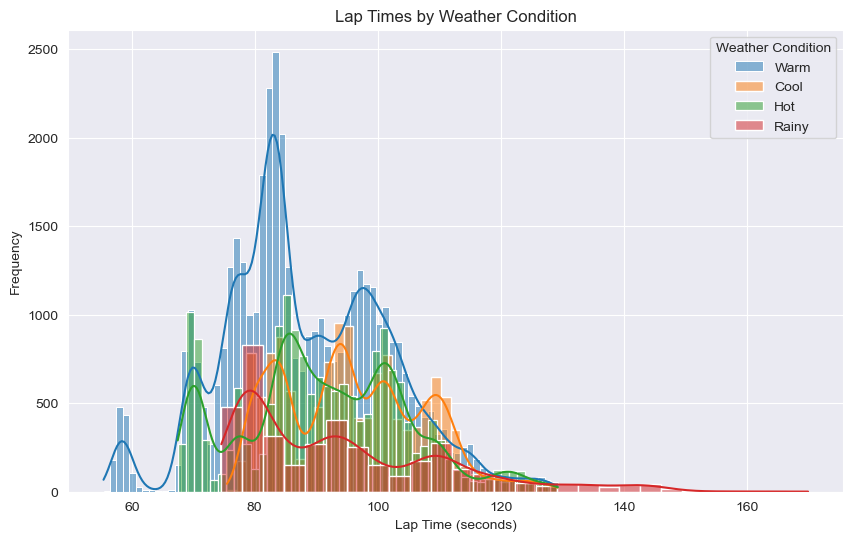

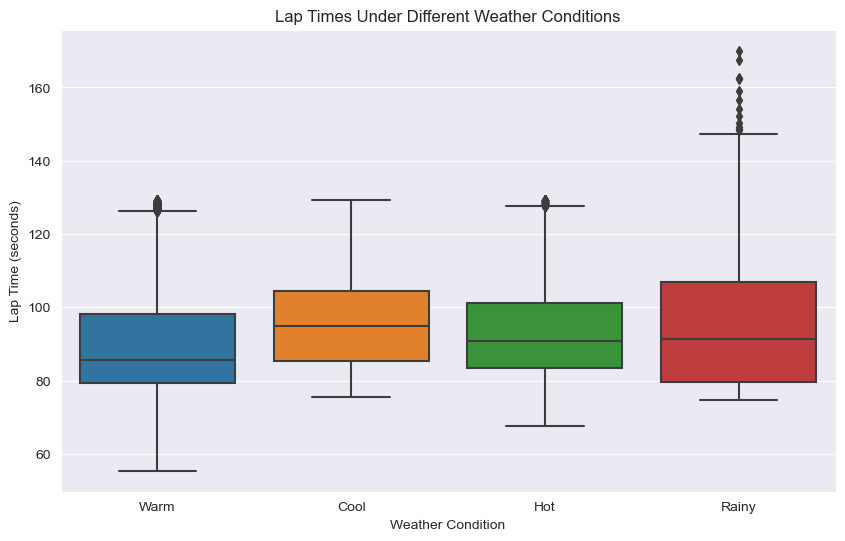

In [15]:
#EDA - Visualization

plt.figure(figsize=(10, 6))

# Unique categories in the 'Original_Weather_Category' column
weather_categories = df['Original_Weather_Category'].unique()
# Plot histogram for each weather category
for category in weather_categories:
    # Select lap times for the current category
    category_lap_times = df[df['Original_Weather_Category'] == category]['LapTime']
    # Plot the distribution of lap times for the category
    sns.histplot(category_lap_times, kde=True, label=category)
    
# Plotting
plt.title('Lap Times by Weather Condition')
plt.xlabel('Lap Time (seconds)')
plt.ylabel('Frequency')
plt.legend(title='Weather Condition')
plt.show()


# Second graph with box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Original_Weather_Category', y='LapTime', data=df)
plt.title('Lap Times Under Different Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Lap Time (seconds)')
plt.show()

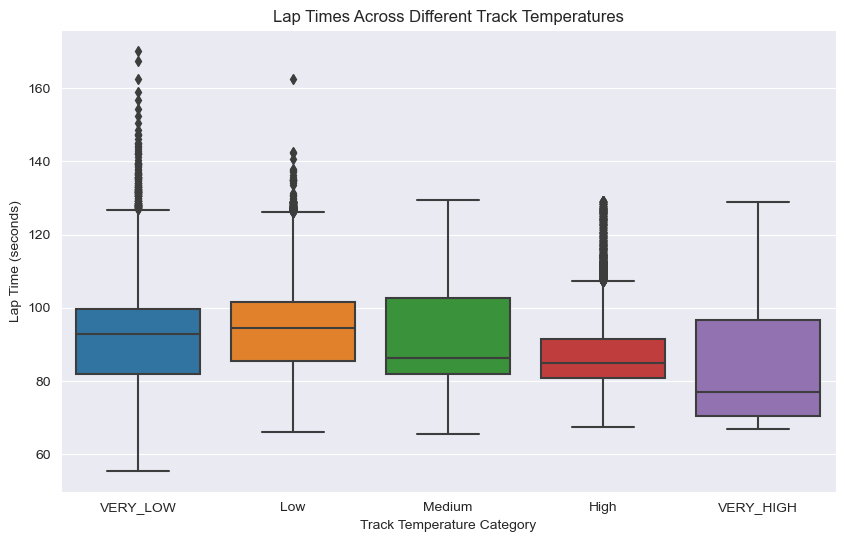

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Original_TrackTemp_Cat', y='LapTime', data=df)
plt.title('Lap Times Across Different Track Temperatures')
plt.xlabel('Track Temperature Category')
plt.ylabel('Lap Time (seconds)')
plt.show()

In [5]:
""" from sklearn.cluster import KMeans

#K-Means to determine thresholds, The centroids of these clusters could reflect potential thresholds.

kmeans = KMeans(n_clusters=3)
df['AirTempCluster'] = kmeans.fit_predict(df[['AirTemp']])

# Check the cluster centers for AirTemp
print(kmeans.cluster_centers_)

kmeans = KMeans(n_clusters=5)  

df['TrackTempCluster'] = kmeans.fit_predict(df[['TrackTemp']])

print(kmeans.cluster_centers_)"""

" from sklearn.cluster import KMeans\n\n#K-Means to determine thresholds, The centroids of these clusters could reflect potential thresholds.\n\nkmeans = KMeans(n_clusters=3)\ndf['AirTempCluster'] = kmeans.fit_predict(df[['AirTemp']])\n\n# Check the cluster centers for AirTemp\nprint(kmeans.cluster_centers_)\n\nkmeans = KMeans(n_clusters=5)  \n\ndf['TrackTempCluster'] = kmeans.fit_predict(df[['TrackTemp']])\n\nprint(kmeans.cluster_centers_)"

In [13]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82418 entries, 0 to 82417
Data columns (total 122 columns):
 #    Column                               Dtype   
---   ------                               -----   
 0    DriverNumber                         int64   
 1    LapTime                              float64 
 2    LapNumber                            float64 
 3    Stint                                float64 
 4    Sector1Time                          float64 
 5    Sector2Time                          float64 
 6    SpeedI1                              float64 
 7    SpeedI2                              float64 
 8    SpeedFL                              float64 
 9    SpeedST                              float64 
 10   TyreLife                             float64 
 11   FreshTyre                            int64   
 12   TrackStatus                          float64 
 13   Position                             float64 
 14   IsAccurate                           int64   
 15   

In [7]:
# Separate
X = df.drop(['LapTime'], axis=1)
y = df['LapTime']

# Check for NaN values in each column
nan_counts = X.isna().sum()
# Print columns with NaN count more than 0
print(nan_counts[nan_counts >0])

# After attempting to fill NaNs with group means
X['Sector1Time'].fillna(X['Sector1Time'].mean(), inplace=True)
X['Sector2Time'].fillna(X['Sector2Time'].mean(), inplace=True)
#X['Sector3Time'].fillna(X['Sector3Time'].mean(), inplace=True)

X['SpeedI1'].fillna(X['SpeedI1'].mean(), inplace=True)
X['SpeedI2'].fillna(X['SpeedI2'].mean(), inplace=True)
X['SpeedFL'].fillna(X['SpeedFL'].mean(), inplace=True)
X['SpeedST'].fillna(X['SpeedST'].mean(), inplace=True)
X['Position'].fillna(X['Position'].mean(), inplace=True)
X['TrackStatus'].fillna(X['TrackStatus'].mean(), inplace=True)

# Check for NaN values in each column
nan_counts = X.isna().sum()

# Print columns with NaN count more than 0
print("Nan values are Imputed : ", nan_counts[nan_counts >0])


Sector1Time                1805
Sector2Time                 166
SpeedI1                   11803
SpeedI2                     212
SpeedFL                    2900
SpeedST                    6483
TrackStatus                  96
Position                     96
Original_TrackTemp_Cat     3497
dtype: int64
Nan values are Imputed :  Original_TrackTemp_Cat    3497
dtype: int64


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split Train and test set for a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remove Strings
X_train = X_train.drop(['Original_Driver', 'Original_Circuit','Original_Weather_Category','Original_TrackTemp_Cat'], axis= 1)

#Fitting a RandomForest model

model = RandomForestRegressor(n_estimators=100,max_depth=20,min_samples_split=5,random_state=42)
# Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}

model.fit(X_train, y_train)

ValueError: Input y contains NaN.

In [ ]:
from sklearn.metrics import mean_squared_error

X_test = X_test.drop(['Original_Driver', 'Original_Circuit','Original_Weather_Category','Original_TrackTemp_Cat'], axis= 1)


# Print RMSE value of the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print(f"RMSE: {rmse}")

In [ ]:
# Shows Important features

importance = model.feature_importances_

# Sort the feature importance
sorted_indices = np.argsort(importance)[::-1]

for index in sorted_indices:
    print(f"{X_train.columns[index]}: {importance[index]}")
